# Introduction to Coil Sets and Green's Functions

#### The purpose of this tutorial is to develop familiarity with the fundamental objects we will need to create, manipulate, and analyze magnetic configurations.

#### The three objectives of this tutorial are enumerated below:
1. Create coil sets and transform them through translations and rotations.
2. Create suitable meshes and using them to create Green's functions for flux and magnetic field components
3. Understand and plot the results of goals 1 and 2

Just like any other python notebook we start with importing standard libraries as well as our project's specific functionality

In [1]:
import numpy as np
import matplotlib as mpl
import matplotlib.pyplot as plt

from pleiades import RectangularCoil

Now we will create an instance of the `RectangularCoil` class as it is by far the most common coil set used for building electromagnets for plasma physics or fusion experiments. We create a `RectangularCoil` by specifying at a minimum the centroid `(r0, z0)` of the regular array of current filaments in cylindrical coordinates and with SI units.

In [2]:
rc1 = RectangularCoil(1, .5, nr=10, nz=10, dr=.01, dz=.01)
rc1.rotate(45, pivot=rc1.centroid)

Now let's see what attributes this coil has

In [3]:
print(rc1.centroid)
print(rc1.area)
print(rc1.current)
print(rc1.current_density/1E6)

[1.  0.5]
0.01
1.0
0.01


Now we will try our hand at plotting some of this data as well as the visulaizations. to access the fields like psi, B_R, and B_Z we simply call their attributes from the brb object as shown below.

In [4]:
from pleiades import RectGrid

grid = RectGrid(rmin=0, rmax=3, zmin=0, zmax=3)
rc1.grid = grid
rc1.psi()

array([0.00000000e+00, 2.02280960e-08, 8.09122841e-08, ...,
       4.59174295e-06, 4.60797354e-06, 4.62333415e-06])

[[0.   0.03 0.06 ... 2.94 2.97 3.  ]
 [0.   0.03 0.06 ... 2.94 2.97 3.  ]
 [0.   0.03 0.06 ... 2.94 2.97 3.  ]
 ...
 [0.   0.03 0.06 ... 2.94 2.97 3.  ]
 [0.   0.03 0.06 ... 2.94 2.97 3.  ]
 [0.   0.03 0.06 ... 2.94 2.97 3.  ]] (101, 101)
[[0.   0.   0.   ... 0.   0.   0.  ]
 [0.03 0.03 0.03 ... 0.03 0.03 0.03]
 [0.06 0.06 0.06 ... 0.06 0.06 0.06]
 ...
 [2.94 2.94 2.94 ... 2.94 2.94 2.94]
 [2.97 2.97 2.97 ... 2.97 2.97 2.97]
 [3.   3.   3.   ... 3.   3.   3.  ]] (101, 101)


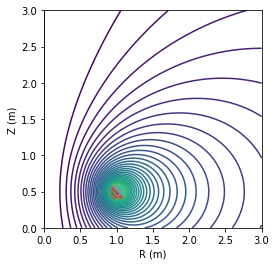

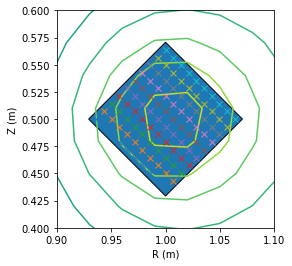

In [5]:
print(grid.R, grid.R.shape)
print(grid.Z, grid.Z.shape)
fig, ax = plt.subplots()
rc1.plot(ax)
ax.contour(grid.R, grid.Z, rc1.psi().reshape(grid.R.shape), 51)
ax.set_xlim(0, 3)
ax.set_ylim(0, 3)
ax.set_aspect(1)
ax.set_xlabel('R (m)')
ax.set_ylabel('Z (m)')
plt.show()
fig, ax = plt.subplots()
rc1.plot(ax)
ax.contour(grid.R, grid.Z, rc1.psi().reshape(grid.R.shape), 11)
ax.set_xlim(.9, 1.1)
ax.set_ylim(.4, .6)
ax.set_aspect(1)
ax.set_xlabel('R (m)')
ax.set_ylabel('Z (m)')
plt.show()